# Transformers

## Self-attention

<p>The fundamental operation of any transformer architecture is the self-attention operation.</p>
Self-attention is a sequence-to-sequence operation: a sequence of vectors goes in, and a sequence of vectors comes out. Let’s call the input vectors $𝐱_1$,$𝐱_2$,…,$𝐱_t$ and the corresponding output vectors $𝐲_1$,$𝐲_2$,…,$𝐲_t$. The vectors all have dimension k. <br>
To produce output vector $𝐲_i$, the self attention operation simply takes <i>a weighted average over all the input vectors</i> <br>
$$\large y_i = \sum\limits_{j}w_{ij}x_j$$<br>
<p>Where j indexes over the whole sequence and the weights sum to one over all j. <b>The weight $w_{ij}$ is not a parameter, as in a normal neural net, but it is derived from a function over $𝐱_i$ and $𝐱_j$</b>. The simplest option for this function is the dot product:</p><br>
$$\large w^{'}_{ij} = x_i^T x_j $$<br>
<p><i>Note that $𝐱_i$ is the input vector at the same position as the current output vector $𝐲_i$. For the next output vector, we get an entirely new series of dot products, and a different weighted sum.</i></p><br>

<p>The dot product gives us a value anywhere between negative and positive infinity, so we apply a softmax to map the values to [0,1] and to ensure that they sum to 1 over the whole sequence:</p><br>
$$\large w_{ij} = \frac{exp w^{'}_{ij}}{\sum\limits_{j} exp w^{'}_{ij}}$$<br>
That’s the basic operation of self attention.<br>

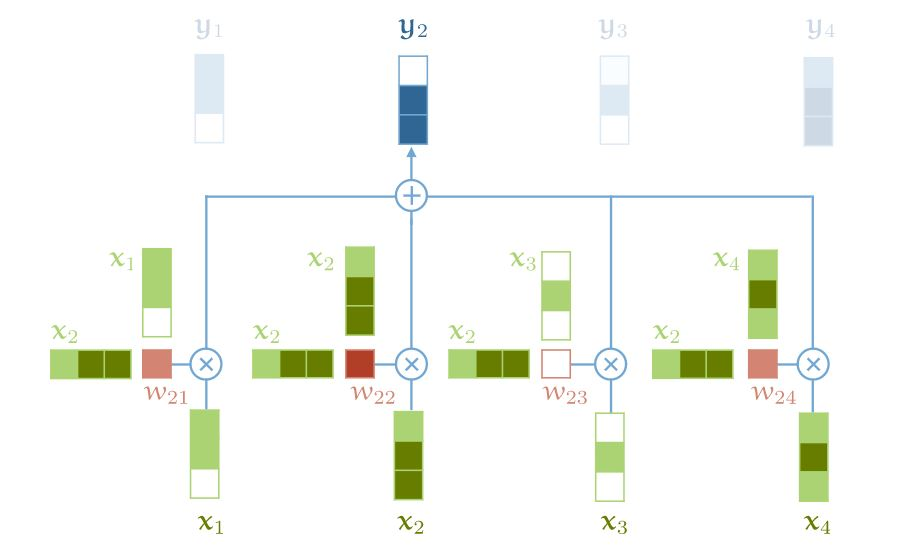<br>

A visual illustration of basic self-attention. Note that the softmax operation over the weights is not illustrated.<br>
This is the only operation in the whole architecture that propagates information between vectors. Every other operation in the transformer is applied to each vector in the input sequence without interactions between vectors.

## Why self-attention works

Let’s say we are faced with a sequence of words. To apply self-attention, we simply assign each word t in our vocabulary an embedding vector $𝐯_t$ (the values of which we’ll learn). This is what’s known as an embedding layer in sequence modeling. It turns the word sequence the,cat,walks,on,the,street into the vector sequence

 $𝐯_{the}$, $𝐯_{cat}$, $𝐯_{walks}$, $𝐯_{on}$, $𝐯_{the}$, $𝐯_{street}$.
If we feed this sequence into a self-attention layer, the output is another sequence of vectors
$𝐲_{the}$, $𝐲_{cat}$, $𝐲_{walks}$, $𝐲_{on}$, $𝐲_{the}$,$𝐲_{street}$
where 𝐲cat is a weighted sum over all the embedding vectors in the first sequence, weighted by their (normalized) dot-product with 𝐯cat.

Since we are learning what the values in 𝐯t should be, how "related" two words are is entirely determined by the task. In most cases, the definite article the is not very relevant to the interpretation of the other words in the sentence; therefore, we will likely end up with an embedding 𝐯the that has a low or negative dot product with all other words. On the other hand, to interpret what walks means in this sentence, it's very helpful to work out who is doing the walking. This is likely expressed by a noun, so for nouns like cat and verbs like walks, we will likely learn embeddings 𝐯cat and 𝐯walks that have a high, positive dot product together.

This is the basic intuition behind self-attention. The dot product expresses how related two vectors in the input sequence are, with “related” defined by the learning task, and the output vectors are weighted sums over the whole input sequence, with the weights determined by these dot products.

- What the basic self-attention actually does is entirely determined by whatever mechanism creates the input sequence. Upstream mechanisms, like an embedding layer, drive the self-attention by learning representations with particular dot products (although we’ll add a few parameters later).
- Self attention sees its input as a set, not a sequence. If we permute the input sequence, the output sequence will be exactly the same, except permuted also (i.e. self-attention is permutation equivariant). We will mitigate this somewhat when we build the full transformer, but the self-attention by itself actually ignores the sequential nature of the input.

## Pytorch Implementation

Expressing the self attention in matrix multiplications. A naive implementation that loops over all vectors to compute the weights and outputs would be much too slow.

We’ll represent the input, a sequence of t vectors of dimension k as a t by k matrix 𝐗. Including a minibatch dimension b, gives us an input tensor of size (b, t, k).

The set of all raw dot products $w^{′}_{ij}$ forms a matrix, which we can compute simply by multiplying 𝐗 by its transpose:


Two matrix multiplications and one softmax gives us a basic self-attention.
The actual self-attention used in modern transformers relies on three additional tricks.
### 1. Queries, keys and values <br>
Every input vector $x_i$ is used in three different ways in the self attention operation:
    . It is compared to every other vector to establish the weights for its own output $y_i$.
    . It is compared to every other vector to establish the weights fot the outputs of the j-th vector $y_j$.
    . It is used as part of the weighted sum to compute each output vector once the weights have been established.

These roles are often called the query, the key and the value. In the basic self-attention we've seen so far, each input vector must play all three roles. We make its life a little easier by deriving new vectors for each role, by applying a linear transformation to the original input vector. In other words, we add three k×k weight matrices $𝐖_q$, $𝐖_k$, $𝐖_v$ and compute three linear transformations of each $x_i$, for the three different parts of the self attention:

$$\large 𝐪_i = 𝐖_q 𝐱_i$$    <br>        $$\large 𝐤_i= 𝐖_k 𝐱_i$$   <br>   $$\large 𝐯_i= 𝐖_v 𝐱_i$$ <br><br>
$$\large w^′_{ij} = 𝐪_i^{T}𝐤_j$$<br>
$$\large w_{ij} = softmax(w^{′}_{ij})$$<br>
$$\large y_i = \sum\limits_{j}w_{ij}𝐯_j$$.<br><br>

This gives the self-attention layer some controllable parameters, and allows it to modify the incoming vectors to suit the three roles they must play.

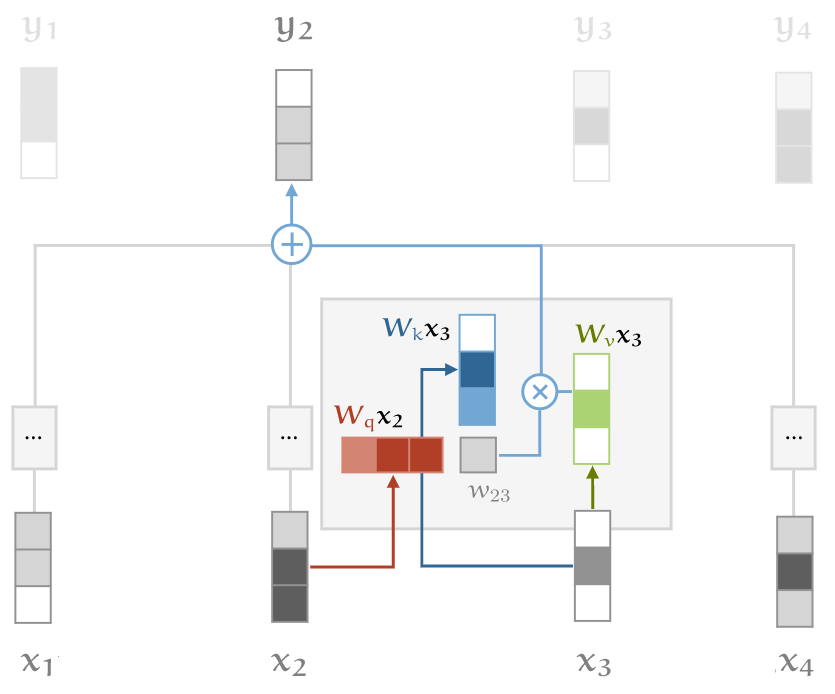

Illustration of the self-attention with <font color='blue'>key</font>, <font color='red'>query</font> and <font color='green'>value</font> transformations.

### 2. Scaling the dot product

The softmax function can be sensitive to very large input values. These kill the gradient, and slow down learning, or cause it to stop altogether. Since the average value of the dot product grows with the embedding dimension k, it helps to scale the dot product back a little to stop the inputs to the softmax function from growing too large: <br>

$$\large w^{'}_{ij} = \frac{q_{i}^{T}k_{j}}{\sqrt{k}}$$

Why $\sqrt k$? Imagine a vector in $ℝ^k$ with values all c. Its Euclidean length is $\sqrt k$c. Therefore, we are dividing out the amount by which the increase in dimension increases the length of the average vectors.

### 3. Multi-head attention

Finally, we must account for the fact that a word can mean different things to different neighbours. Consider the following example. mary,gave,roses,to,susan We see that the word gave has different relations to different parts of the sentence. mary expresses who’s doing the giving, roses expresses what’s being given, and susan expresses who the recipient is.

In a single self-attention operation, all this information just gets summed together. If Susan gave Mary the roses instead, the output vector 𝐲gave would be the same, even though the meaning has changed.

We can give the self attention greater power of discrimination, by combining several self attention mechanisms (which we'll index with r), each with different matrices $𝐖^r_q$, $𝐖^r_k$, $𝐖^r_v$. These are called attention heads.

For input $𝐱_i$ each attention head produces a different output vector $𝐲^r_i$. We concatenate these, and pass them through a linear transformation to reduce the dimension back to k.

In [2]:
import torch
from torch import nn
import torch.nn.functional as F

In [4]:
class selfAttension(nn.Module):
    def __init__(self, k, heads = 8):
        super().__init__()
        self.k, self.heads = k, heads
        # These compute the queries, keys and values for all 
        # heads (as a single concatenated vector)
        self.tokeys    = nn.Linear(k, k * heads, bias=False)
        self.toqueries = nn.Linear(k, k * heads, bias=False)
        self.tovalues  = nn.Linear(k, k * heads, bias=False)

        # This unifies the outputs of the different heads into 
        # a single k-vector
        self.unifyheads = nn.Linear(heads * k, k)
    
    def forward(self, x):
        b, t, k = x.size()
        h = self.heads
        queries = self.toqueries(x).view(b, t, h, k)
        keys    = self.tokeys(x).view(b, t, h, k)
        values  = self.tovalues(x).view(b, t, h, k)
        
         # - fold heads into the batch dimension
        keys = keys.transpose(1, 2).contiguous().view(b * h, t, k)
        queries = queries.transpose(1, 2).contiguous().view(b * h, t, k)
        values = values.transpose(1, 2).contiguous().view(b * h, t, k)
           
        queries = queries / (k ** (1/4))
        keys    = keys / (k ** (1/4))
        
        # - get dot product of queries and keys, and scale
        dot = torch.bmm(queries, keys.transpose(1, 2))
        # - dot has size (b*h, t, t) containing raw weights
        
        dot = F.softmax(dot, dim=2) 
        # - dot now contains row-wise normalized weights
        
        # apply the self attention to the values
        out = torch.bmm(dot, values).view(b, h, t, k)
        
        # swap h, t back, unify heads
        out = out.transpose(1, 2).contiguous().view(b, t, h * k)
        return self.unifyheads(out)

We think of the h attention heads as h separate sets of three matrices $𝐖^r_q$, $𝐖^r_k$, $𝐖^r_v$, but it's actually more efficient to combine these for all heads into three single k×hk matrices, so that we can compute all the concatenated queries, keys and values in a single matrix multiplication.
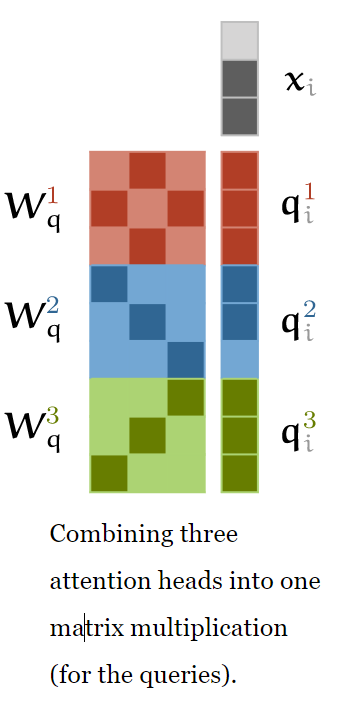

The output of each linear module has size (b, t, h*k), which we simply reshape to (b, t, h, k) give each head its own dimension.

Next, we need to compute the dot products. This is the same operation for every head, so we fold the heads into the batch dimension. This ensures that we can use torch.bmm() as before, and the whole collection of keys, queries and values will just be seen as a slightly larger batch.

Since the head and batch dimension are not next to each other, we need to transpose before we reshape. (This is costly, but it seems to be unavoidable.)

As before, the dot products can be computed in a single matrix multiplication, but now between the queries and the keys.

Before that, however, we move the scaling of the dot product by k−−√ back and instead scale the keys and queries by k−−√4 before multiplying them together. This should save memory for longer sequences.

To unify the attention heads, we transpose again, so that the head dimension and the embedding dimension are next to each other, and reshape to get concatenated vectors of dimension kh. We then pass these through the unifyheads layer to project them back down to k dimensions.

In [7]:
from former import utils
from utils import mask_

In [5]:
import torch
from torch import nn
import torch.nn.functional as F

import random, math

class SelfAttention(nn.Module):
    def __init__(self, emb, heads=8, mask=False):

        super().__init__()

        self.emb = emb
        self.heads = heads
        self.mask = mask

        self.tokeys = nn.Linear(emb, emb * heads, bias=False)
        self.toqueries = nn.Linear(emb, emb * heads, bias=False)
        self.tovalues = nn.Linear(emb, emb * heads, bias=False)

        self.unifyheads = nn.Linear(heads * emb, emb)

    def forward(self, x):

        b, t, e = x.size()
        h = self.heads
        assert e == self.emb, f'Input embedding dim ({e}) should match layer embedding dim ({self.emb})'

        keys    = self.tokeys(x).view(b, t, h, e)
        queries = self.toqueries(x).view(b, t, h, e)
        values  = self.tovalues(x).view(b, t, h, e)

        # compute scaled dot-product self-attention

        # - fold heads into the batch dimension
        keys = keys.transpose(1, 2).contiguous().view(b * h, t, e)
        queries = queries.transpose(1, 2).contiguous().view(b * h, t, e)
        values = values.transpose(1, 2).contiguous().view(b * h, t, e)

        # - get dot product of queries and keys, and scale
        dot = torch.bmm(queries, keys.transpose(1, 2))
        dot = dot / math.sqrt(e) # dot contains b*h  t-by-t matrices with raw self-attention logits

        assert dot.size() == (b*h, t, t), f'Matrix has size {dot.size()}, expected {(b*h, t, t)}.'

        if self.mask: # mask out the lower half of the dot matrix,including the diagonal
            mask_(dot, maskval=float('-inf'), mask_diagonal=False)

        dot = F.softmax(dot, dim=2) # dot now has row-wise self-attention probabilities

        assert not utils.contains_nan(dot[:, 1:, :]) # only the forst row may contain nan

        if self.mask == 'first':
            dot = dot.clone()
            dot[:, :1, :] = 0.0
            # - The first row of the first attention matrix is entirely masked out, so the softmax operation results
            #   in a division by zero. We set this row to zero by hand to get rid of the NaNs

        # apply the self attention to the values
        out = torch.bmm(dot, values).view(b, h, t, e)

        # swap h, t back, unify heads
        out = out.transpose(1, 2).contiguous().view(b, t, h * e)

        return self.unifyheads(out)

class TransformerBlock(nn.Module):
    def __init__(self, emb, heads, mask, seq_length, ff_hidden_mult=4, dropout=0.0):
        super().__init__()

        self.attention = SelfAttention(emb, heads=heads, mask=mask)
        self.mask = mask

        self.norm1 = nn.LayerNorm(emb)
        self.norm2 = nn.LayerNorm(emb)

        self.ff = nn.Sequential(
            nn.Linear(emb, ff_hidden_mult * emb),
            nn.ReLU(),
            nn.Linear(ff_hidden_mult * emb, emb)
        )

        self.do = nn.Dropout(dropout)

    def forward(self, x):

        attended = self.attention(x)

        x = self.norm1(attended + x)

        x = self.do(x)

        fedforward = self.ff(x)

        x = self.norm2(fedforward + x)

        x = self.do(x)

        return x

In [9]:
from utils import d

class GTransformer(nn.Module):
    """
    Transformer for generating text (character by character).
    """

    def __init__(self, emb, heads, depth, seq_length, num_tokens):
        super().__init__()

        self.num_tokens = num_tokens
        self.token_embedding = nn.Embedding(embedding_dim=emb, num_embeddings=num_tokens)
        self.pos_embedding = nn.Embedding(embedding_dim=emb, num_embeddings=seq_length)

        self.unify_embeddings = nn.Linear(2*emb, emb)

        tblocks = []
        for i in range(depth):
            tblocks.append(
                TransformerBlock(emb=emb, heads=heads, seq_length=seq_length, mask=True))

        self.tblocks = nn.Sequential(*tblocks)

        self.toprobs = nn.Linear(emb, num_tokens)

    def forward(self, x):
        """
        :param x: A batch by sequence length integer tensor of token indices.
        :return: predicted log-probability vectors for each token based on the preceding tokens.
        """
        tokens = self.token_embedding(x)
        b, t, e = tokens.size()

        positions = self.pos_embedding(torch.arange(t, device=d()))[None, :, :].expand(b, t, e)
        x = self.unify_embeddings(torch.cat((tokens, positions), dim=2).view(-1, 2*e)).view(b, t, e)

        x = self.tblocks(x)

        x = self.toprobs(x.view(b*t, e)).view(b, t, self.num_tokens)

        return F.log_softmax(x, dim=2)

class CTransformer(nn.Module):
    """
    Transformer for classifying sequences
    """

    def __init__(self, emb, heads, depth, seq_length, num_tokens, num_classes, max_pool=True, dropout=0.0):
        """
        :param emb: Embedding dimension
        :param heads: nr. of attention heads
        :param depth: Number of transformer blocks
        :param seq_length: Expected maximum sequence length
        :param num_tokens: Number of tokens (usually words) in the vocabulary
        :param num_classes: Number of classes.
        :param max_pool: If true, use global max pooling in the last layer. If false, use global
                         average pooling.
        """
        super().__init__()

        self.num_tokens, self.max_pool = num_tokens, max_pool

        self.token_embedding = nn.Embedding(embedding_dim=emb, num_embeddings=num_tokens)
        self.pos_embedding = nn.Embedding(embedding_dim=emb, num_embeddings=seq_length)

        self.unify_embeddings = nn.Linear(2 * emb, emb)

        tblocks = []
        for i in range(depth):
            tblocks.append(
                TransformerBlock(emb=emb, heads=heads, seq_length=seq_length, mask=False, dropout=dropout))

        self.tblocks = nn.Sequential(*tblocks)

        self.toprobs = nn.Linear(emb, num_classes)

        self.do = nn.Dropout(dropout)

    def forward(self, x):
        """
        :param x: A batch by sequence length integer tensor of token indices.
        :return: predicted log-probability vectors for each token based on the preceding tokens.
        """
        tokens = self.token_embedding(x)
        b, t, e = tokens.size()

        positions = self.pos_embedding(torch.arange(t, device=d()))[None, :, :].expand(b, t, e)
        x = self.unify_embeddings(torch.cat((tokens, positions), dim=2).view(-1, 2 * e)).view(b, t, e)
        x = self.do(x)

        x = self.tblocks(x)

        x = x.max(dim=1)[0] if self.max_pool else x.mean(dim=1) # pool over the time dimension

        x = self.toprobs(x)

        return F.log_softmax(x, dim=1)